## Variational Autoencoder Model

In [1]:
# dependencies
from utils.paths import project_root
from dataloaders.sliding_window import LogsSlidingWindow
from utils.plots import plot_anomaly_detection_analysis, plot_failure_analysis
from dataloaders.bert import BertLogEmbedder

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import polars as pl
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

import os
import gc

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from sklearn.metrics import (average_precision_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
                        classification_report, auc, f1_score, precision_score, recall_score)
from sklearn.model_selection import KFold, TimeSeriesSplit, ParameterGrid
import seaborn as sns

import itertools
import gc
import copy
import matplotlib.pyplot as plt

/home/paulofr/miniforge3/envs/MLP/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configuration
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

assert pyro.__version__.startswith('1.9.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
smoke_test = 'CI' in os.environ

Using device: cuda


In [3]:
# loading and preparing the data
df = pl.read_csv(f"{project_root()}/data/parsed/cleaned_BGL_structured.csv")[['Timestamp', 'EventId', 'Label', 'Content']]

# convert Timestamp to polars Timestamp
df = df.with_columns(
    pl.from_epoch(pl.col("Timestamp"), time_unit="s").alias("Timestamp")
)

# filter only logs without anomaly labels "-"
df_all = df.with_columns(
    (pl.col("Label") != "-").alias("Anomaly")
)

df_all.head()

Timestamp,EventId,Label,Content,Anomaly
datetime[μs],str,str,str,bool
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false
2005-06-03 22:42:50,"""3aa50e45""","""-""","""instruction cache parity error…",false


In [4]:
# train test spit
split_point = int(len(df_all) * 0.8)
train_df = df_all[:split_point]
test_df = df_all[split_point:]

In [5]:
# auxiliary functions to try load all data into vram or use batches
def get_available_vram_gb():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        free_mem = torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)
        return free_mem / (1024**3)
    return 0

def estimate_tensor_size_gb(shape, dtype=torch.float32):
    bytes_per_element = torch.tensor([], dtype=dtype).element_size()
    total_elements = 1
    for dim in shape:
        total_elements *= dim
    return (total_elements * bytes_per_element) / (1024**3)

def precompute_windows(dataset):
    print(f"Pre-computing {len(dataset)} windows...")
    
    n_samples = len(dataset)
    input_dim = dataset.input_dim
    n_failures = dataset.n_failure_types
    
    X = torch.zeros((n_samples, input_dim), dtype=torch.float32)
    y = torch.zeros((n_samples,), dtype=torch.long)
    pred_types = torch.zeros((n_samples), dtype=torch.long)
    failure_types = torch.zeros((n_samples, n_failures), dtype=torch.float32)
    
    for i in tqdm(range(n_samples)):
        count_vec, label, pred_type, failure_types_vec = dataset[i]
        X[i] = count_vec
        y[i] = label
        pred_types[i] = pred_type
        failure_types[i] = failure_types_vec
        
    print("Dataset converted to Tensor")
    return X, y, pred_types, failure_types

In [6]:
# create datasets
def load_dataset(
        train_dataframe: pl.DataFrame,
        test_dataframe: pl.DataFrame,
        window_size='5m', 
        step_size='1m',
        n_prediction_window=3, 
        filter_strategy='label', 
        filter_params={'contamination': 0.01},
        batch_size=4096,
        embedder=None,
        mode='count',
        debug=False
    ) -> dict:
    
    train_dataset = LogsSlidingWindow(
        train_dataframe, 
        window_size=window_size,   
        step_size=step_size,
        n_prediction_window=n_prediction_window,
        filter_strategy=filter_strategy,
        filter_params=filter_params,
        embedder=embedder,
        mode=mode
    )

    train_event_ids = train_dataset.event_ids
    INPUT_DIM = train_dataset.input_dim

    test_dataset = LogsSlidingWindow(
        test_dataframe,
        window_size=window_size,
        step_size=step_size, 
        n_prediction_window=n_prediction_window,
        event_ids=train_event_ids,  # use same event IDs as training set
        filter_strategy='none', # keep all logs for evaluation
        embedder=embedder,
        mode=mode
    )

    X_train, y_train, pred_types_train, failure_types_train = precompute_windows(train_dataset)
    X_test, y_test, pred_types_test, failure_types_test = precompute_windows(test_dataset)

    available_vram = get_available_vram_gb()
    train_size_gb = estimate_tensor_size_gb(X_train.shape, X_train.dtype)
    test_size_gb = estimate_tensor_size_gb(X_test.shape, X_test.dtype)
    total_size_gb = train_size_gb + test_size_gb

    safety_factor = 1.4
    required_vram = total_size_gb * safety_factor

    if debug:
        print(f"Available VRAM: {available_vram:.2f} GB")
        print(f"Required VRAM: {required_vram:.2f} GB (train: {train_size_gb:.2f} GB, test: {test_size_gb:.2f} GB)")

    USE_VRAM = required_vram < available_vram
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == 'cuda' and USE_VRAM:
        if debug:
            print("Sufficient VRAM available - loading data to GPU")
        X_train = X_train.to(device)
        X_test = X_test.to(device)
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        return {
            "mode": "tensor",
            "device": device,
            "input_dim": INPUT_DIM,
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
            "pred_types_train": pred_types_train,
            "pred_types_test": pred_types_test,
            "failure_types_train": failure_types_train,
            "failure_types_test": failure_types_test,
            "failure_map_train": train_dataset.get_failure_map(),
            "failure_map_test": test_dataset.get_failure_map(),
        }
    
    if debug:
        print("Insufficient VRAM or unavailable GPU - using DataLoader")
    batch_size = batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=(device.type == "cuda"))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=(device.type == "cuda"))

    return {
        "mode": "dataloader",
        "device": device,
        "input_dim": INPUT_DIM,
        "train_dataset": train_dataset,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "pred_types_train": pred_types_train,
        "pred_types_test": pred_types_test,
        "failure_types_train": failure_types_train,
        "failure_types_test": failure_types_test,
        "failure_map_train": train_dataset.get_failure_map,
        "failure_map_test": test_dataset.get_failure_map,
    }


In [7]:
def get_vram_batches(X, batch_size=4096, shuffle=True):
    n_samples = X.shape[0]
    indices = torch.arange(n_samples, device=X.device)
    
    if shuffle:
        indices = torch.randperm(n_samples, device=X.device)
        
    for start_idx in range(0, n_samples, batch_size):
        batch_indices = indices[start_idx : start_idx + batch_size]
        yield X[batch_indices]

## Variational Autoencoder Neural Network

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_loc = nn.Linear(hidden_dim, z_dim)    # latent mean
        self.fc2_scale = nn.Linear(hidden_dim, z_dim)  # latent scale
        self.activation = nn.LeakyReLU(0.2)
        self.bn = nn.BatchNorm1d(input_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)

        x = self.bn(x)

        hidden = self.activation(self.fc1(x))
        z_loc = self.fc2_loc(hidden)

        z_log_scale = self.fc2_scale(hidden)

        z_log_scale = torch.clamp(z_log_scale, min=-2, max=2)

        # we need positive scale, so we exponentiate the output
        z_scale = torch.exp(z_log_scale)

        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, input_dim, z_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        
        # predicts the reconstructed value (mean)
        self.fc_loc = nn.Linear(hidden_dim, input_dim)
        
        # predicts the variance/scale
        self.fc_scale = nn.Linear(hidden_dim, input_dim)
        
        self.activation = nn.LeakyReLU(0.2)
        self.softplus = nn.Softplus()

    def forward(self, z):
        hidden = self.activation(self.fc1(z))
        
        # reconstructed Mean
        loc_img = self.softplus(self.fc_loc(hidden))
        
        # reconstructed variance/scale
        log_scale = self.fc_scale(hidden)
        log_scale = torch.clamp(log_scale, min=-5, max=2)  
        scale_img = torch.exp(log_scale)
        
        return loc_img, scale_img

In [9]:
class LogAnomalyVAE(nn.Module):
    def __init__(self, input_dim=390, z_dim=32, hidden_dim=128, use_cuda=False):
        super().__init__()
        self.encoder = Encoder(input_dim, z_dim, hidden_dim)
        self.decoder = Decoder(input_dim, z_dim, hidden_dim)
        self.input_dim = input_dim
        self.z_dim = z_dim
        
        if use_cuda:
            self.cuda()
            
    def model(self, x):
        pyro.module("decoder", self.decoder)        
        with pyro.plate("data", x.shape[0]):
            # prior: normal N(0, 1)
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            
            # sample latent Z
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode z -> predicted mean and variance for the logs
            recon_loc, recon_scale = self.decoder(z)
            
            # observe 'x' (the real log-counts)
            pyro.sample("obs", dist.Normal(recon_loc, recon_scale).to_event(1), 
                        obs=x.reshape(-1, self.input_dim))

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use encoder to guess Z
            z_loc, z_scale = self.encoder(x)
            
            # sample Z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def get_anomaly_score(self, x, n_samples=10):
        x = x.to(next(self.parameters()).device)
        
        z_loc, z_scale = self.encoder(x)
        q_z = dist.Normal(z_loc, z_scale)
        
        # sample multiple z's at once [n_samples, batch_size, z_dim]
        z = q_z.rsample((n_samples,))
        
        # decode all samples [n_samples * batch_size, input_dim]
        z_flat = z.reshape(-1, self.z_dim)
        recon_loc, recon_scale = self.decoder(z_flat)
        
        # reshape to [n_samples, batch_size, input_dim]
        recon_loc = recon_loc.reshape(n_samples, x.shape[0], -1)
        recon_scale = recon_scale.reshape(n_samples, x.shape[0], -1)
        
        # reconstruction log likelihood: log p(x|z)
        x_expanded = x.reshape(1, x.shape[0], -1).expand(n_samples, -1, -1)
        log_p_x_given_z = dist.Normal(recon_loc, recon_scale).log_prob(x_expanded).sum(dim=-1)
        
        # KL divergence: KL(q(z|x) || p(z)) where p(z) = N(0, I)
        prior = dist.Normal(
            torch.zeros_like(z_loc), 
            torch.ones_like(z_scale)
        )
        kl_div = torch.distributions.kl_divergence(q_z, prior).sum(dim=-1)
        
        # ELBO = E[log p(x|z)] - KL(q(z|x) || p(z))
        # anomaly score = -ELBO (higher = more anomalous)
        elbo = log_p_x_given_z.mean(dim=0) - kl_div
        
        return -elbo

## Training and Evaluating

In [10]:
def train_vae(
    vae,
    data,
    num_epochs=150,
    batch_size=4096,
    lr=1e-3,
    debug=False
):
    pyro.clear_param_store()

    optimizer = Adam({"lr": lr})
    svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

    epoch_losses = []
    epoch_iter = range(num_epochs)
    if debug:
        epoch_iter = tqdm(epoch_iter, desc="Training VAE", leave=True)


    for epoch in epoch_iter:
        epoch_loss = 0.0
        num_samples = 0

        if data["mode"] == "tensor":
            X_train = data["X_train"]

            for x_batch in get_vram_batches(
                X_train,
                batch_size=batch_size,
                shuffle=True
            ):
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        else:
            train_loader = data["train_loader"]
            device = data["device"]

            for x_batch, *_ in train_loader:
                x_batch = x_batch.to(device, non_blocking=True)
                loss = svi.step(x_batch)
                epoch_loss += loss
                num_samples += x_batch.size(0)

        avg_loss = epoch_loss / num_samples
        epoch_losses.append(avg_loss)

    vae.eval() 
    total_clean_loss = 0.0
    total_samples = 0
    
    with torch.no_grad():
        if data["mode"] == "tensor":
             for x_batch in get_vram_batches(data["X_train"], batch_size=4096, shuffle=False):
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)
        else:
             for x_batch, *_ in data["train_loader"]:
                 x_batch = x_batch.to(data["device"])
                 total_clean_loss += svi.evaluate_loss(x_batch)
                 total_samples += x_batch.size(0)

    if debug:
        final_clean_loss = total_clean_loss / total_samples
        print(f"Final Standardized Train Loss: {final_clean_loss:.4f}")

        plt.figure(figsize=(12, 8))
        plt.plot(epoch_losses, linewidth=2)
        plt.xlabel("Epoch")
        plt.ylabel("Average ELBO Loss")
        plt.title("VAE Training Loss")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

    return epoch_losses

In [11]:
def test_vae(
    vae,
    data,
    eval_batch_size=8192
):
    print("Starting evaluation...")
    vae.eval()

    all_scores = []
    all_labels = []

    with torch.no_grad():
        if data["mode"] == "tensor":
            X_test = data["X_test"]
            y_test = data["y_test"]

            num_samples = X_test.shape[0]

            for start_idx in range(0, num_samples, eval_batch_size):
                end_idx = min(start_idx + eval_batch_size, num_samples)

                x_batch = X_test[start_idx:end_idx]
                y_batch = y_test[start_idx:end_idx]

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

        else:
            test_loader = data["test_loader"]
            device = data["device"]

            for x_batch, y_batch, *_ in test_loader:
                x_batch = x_batch.to(device, non_blocking=True)

                scores = vae.get_anomaly_score(x_batch)

                all_scores.append(scores)
                all_labels.append(y_batch)

    scores = torch.cat(all_scores).cpu().numpy()
    labels = torch.cat(all_labels).cpu().numpy()

    print(f"Evaluation complete. Processed {len(scores)} samples.")

    return scores, labels

## Hyperparameter tuning (non-bayesian)

In [12]:
def check_label_distribution(n_splits=5, gap_windows=5):
    data = load_dataset(
        train_df,
        test_df,
        window_size='5m',
        step_size='1m',
        n_prediction_window=3,
        filter_strategy='combined',
        filter_params={'contamination':0.01},
        batch_size=4096
    )
    labels = data['y_train']

    tscv = KFold(n_splits=n_splits)
    indices = np.arange(len(labels))
    
    print("\n=== Label Distribution Across Folds ===")
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(indices)):
        train_anomalies = labels[train_idx].sum()
        val_anomalies = labels[val_idx].sum()
        
        print(f"\nFold {fold_idx + 1}:")
        print(f"  Train: {train_anomalies}/{len(train_idx)} anomalies ({100*train_anomalies/len(train_idx):.2f}%)")
        print(f"  Val: {val_anomalies}/{len(val_idx)} anomalies ({100*val_anomalies/len(val_idx):.2f}%)")

#check_label_distribution()

In [ ]:
def tune_vae_hyperparameters(data, param_grid, n_splits=3, gap_windows=5):
    kf = KFold(n_splits=n_splits, shuffle=False)

    grid = ParameterGrid(param_grid)
    
    best_loss = float('inf')
    best_params = None
    device = data["device"]
    
    if data["mode"] == "tensor":
        X_all = data["X_train"] 
        total_samples = X_all.size(0)
        print(f"Using direct VRAM slicing on {total_samples} samples.")
        
    else:
        if "train_dataset" not in data:
            raise ValueError("In 'dataloader' mode, load_dataset must return 'train_dataset' for CV splitting.")
        dataset = data["train_dataset"]
        total_samples = len(dataset)
        print("Using DataLoader Subsets (Slower).")

    indices = np.arange(total_samples)

    # grid search
    for params in grid:
        print(f"\nTesting: {params}")
        fold_losses = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(indices)):
            pyro.clear_param_store()

            val_start = val_idx.min()
            val_end = val_idx.max()
            mask_safe = ~((train_idx >= val_start - gap_windows) & (train_idx <= val_end + gap_windows))
            train_idx_purged = train_idx[mask_safe]
            
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=params['z_dim'],
                hidden_dim=params['hidden_dim'],
                use_cuda=(device.type == "cuda")
            )
            
            optimizer = Adam({"lr": params['lr']})
            svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
            
            if data["mode"] == "tensor":
                X_fold_train = X_all[train_idx_purged] 
                X_fold_val = X_all[val_idx]
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    
                    for x_batch in get_vram_batches(X_fold_train, params['batch_size'], shuffle=True):
                        loss = svi.step(x_batch)
                        epoch_loss += loss
                        num_samples += x_batch.size(0)
                    
                    if epoch == params['epochs']-1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"--- Fold {fold_idx+1} Final epoch training loss: {avg_epoch_loss:.2f}")
                        
                # Evaluate validation loss
                val_loss = 0.0
                val_samples = 0
                for x_val_batch in get_vram_batches(X_fold_val, batch_size=4096, shuffle=False):
                    val_loss += svi.evaluate_loss(x_val_batch)
                    val_samples += x_val_batch.size(0)
                
                avg_val_loss = val_loss / val_samples

            else:
                train_sub = Subset(dataset, train_idx_purged)
                val_sub = Subset(dataset, val_idx)
                
                train_loader = DataLoader(train_sub, batch_size=params['batch_size'], shuffle=True, num_workers=0)
                val_loader = DataLoader(val_sub, batch_size=4096, shuffle=False, num_workers=0)
                
                for epoch in range(params['epochs']):
                    epoch_loss = 0.0
                    num_samples = 0
                    for x_batch, *_ in train_loader:
                        x_batch = x_batch.to(device)
                        loss = svi.step(x_batch)  # ✅ FIX: Capture the return value
                        epoch_loss += loss
                        num_samples += x_batch.size(0)

                    if epoch == params['epochs']-1:
                        avg_epoch_loss = epoch_loss / num_samples
                        print(f"--- Fold {fold_idx+1} Final epoch training loss: {avg_epoch_loss:.2f}")
                        
                val_loss = 0.0
                val_samples = 0
                for x_batch, *_ in val_loader:
                    x_batch = x_batch.to(device)
                    val_loss += svi.evaluate_loss(x_batch)
                    val_samples += x_batch.size(0)
                
                avg_val_loss = val_loss / val_samples

            fold_losses.append(avg_val_loss)
            print(f"--- Fold {fold_idx+1} Validation loss: {avg_val_loss:.2f}")

        avg_loss = np.mean(fold_losses)
        print(f"-> Avg CV loss: {avg_loss:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_params = params

    print(f"\nWINNER: {best_params} (Loss: {best_loss:.4f})")
    return best_params, best_loss

In [ ]:
def run_nested_grid_search(df, test_df, dataset_grid, model_grid, full_training_epochs=120):
    results = []    
    keys, values = zip(*dataset_grid.items())
    ds_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    print(f"total dataset configurations: {len(ds_combinations)}")
    
    for i, ds_params in enumerate(ds_combinations):
        print(f"\n{'='*50}")
        print(f"OUTER LOOP {i+1}/{len(ds_combinations)}")
        print(f"params: {ds_params}")
        print(f"{'='*50}")
        
        data = None
        vae = None
    
        try:
            embedder = BertLogEmbedder()
            embedder.fit(train_df)

            data = load_dataset(
                train_df,
                test_df,
                window_size=ds_params['window_size'],
                step_size=ds_params['step_size'],
                n_prediction_window=ds_params['n_prediction_window'],
                filter_strategy=ds_params['filter_strategy'],
                filter_params=ds_params['filter_params'],
                batch_size=4096,
                embedder=embedder,
                mode=ds_params['mode']
            )
            
            if data['mode'] == 'tensor':
                n_pred = ds_params['n_prediction_window']
                w_mins = int(ds_params['window_size'].replace('m','')) # assuming 'm' format
                s_mins = int(ds_params['step_size'].replace('m',''))
                
                window_indices = w_mins // s_mins
                gap_indices = window_indices + n_pred
            else:
                ds = data['train_dataset']
                gap_seconds = ds.window_size.total_seconds() + ds.prediction_horizon.total_seconds()
                step_seconds = ds.step_size.total_seconds()
                gap_indices = int(gap_seconds / step_seconds)

            print("-- running inner CV for model params...")
            best_model_params, best_cv_loss = tune_vae_hyperparameters(
                data, 
                model_grid, 
                n_splits=5, 
                gap_windows=gap_indices
            )
                        
            print("-- retraining best model on full")
            vae = LogAnomalyVAE(
                input_dim=data['input_dim'],
                z_dim=best_model_params['z_dim'],
                hidden_dim=best_model_params['hidden_dim'],
                use_cuda=(data["device"].type == "cuda")
            )
            
            train_vae(
                vae, 
                data, 
                num_epochs=full_training_epochs, 
                batch_size=best_model_params['batch_size'],
                lr=best_model_params['lr']
            )
            
            print("-- evaluating on test set...")
            scores, labels = test_vae(vae, data, eval_batch_size=8192)
            
            roc = roc_auc_score(labels, scores)
            pr_auc = average_precision_score(labels, scores)
            
            print(f"--> RESULT: ROC AUC: {roc:.4f} | PR AUC: {pr_auc:.4f}")
            
            results.append({
                **ds_params,
                **best_model_params,
                'cv_reconstruction_loss': best_cv_loss,
                'test_roc_auc': roc,
                'test_pr_auc': pr_auc,
            })
            
        except Exception as e:
            print(f"CRASHED on config {ds_params} !!!")
            print(e)
            import traceback
            traceback.print_exc()
            
        finally:            
            if vae is not None: del vae
            if data is not None: del data
            gc.collect()
            torch.cuda.empty_cache()
                
    return pd.DataFrame(results)

In [ ]:
dataset_grid = {
    'window_size': ['5m', '10m'],
    'step_size': ['1m', '2m'],
    'n_prediction_window': [1, 3, 6],
    'filter_strategy': ['combined'],
    'filter_params': [{'contamination': 0.005}, {'contamination': 0.01}, {'contamination': 0.05}],
    'mode': ['count', 'hybrid']
}

model_grid = {
    'z_dim': [16, 32, 64],
    'hidden_dim': [128, 256],
    'lr': [1e-3, 1e-4],
    'batch_size': [4096],
    'epochs': [30]
}

df_results = run_nested_grid_search(df, test_df, dataset_grid, model_grid)
df_results

Encoding 268359 unique Drain templates...


Batches: 100%|██████████| 4194/4194 [00:30<00:00, 137.18it/s]


Embeddings ready. Dimension: 384
Sorted 3770794 rows by timestamp
Found 35 failure types: ['APPALLOC', 'APPBUSY', 'APPCHILD', 'APPREAD', 'APPRES', 'APPSEV', 'APPTORUS', 'APPUNAV', 'KERNBIT', 'KERNCON', 'KERNDTLB', 'KERNEXT', 'KERNFLOAT', 'KERNMC', 'KERNMICRO', 'KERNMNT', 'KERNMNTF', 'KERNNOETH', 'KERNPAN', 'KERNPOW', 'KERNPROG', 'KERNREC', 'KERNRTSA', 'KERNRTSP', 'KERNSOCK', 'KERNSTOR', 'KERNTERM', 'LINKDISC', 'LINKIAP', 'LINKPAP', 'MASABNORM', 'MASNORM', 'MMCS', 'MONNULL', 'MONPOW']
Found 293 unique event types
Prediction Horizon: +0:05:00 beyond current window
Checking for failures in the next 5 sliding windows.
Period -> Start time: 2005-06-03 22:42:50, End time: 2005-11-03 23:11:48
Generated 220339 sliding windows
Building index...
Index built. Shape: (220339, 3)
Isolation Forest: Removed 22033 windows (10.0%)
Remaining windows: 198306
Sorted 942699 rows by timestamp
Found 27 failure types: ['APPCHILD', 'APPOUT', 'APPRES', 'APPSEV', 'APPTO', 'APPTORUS', 'KERNCON', 'KERNDTLB', 'KERN

100%|██████████| 198306/198306 [00:31<00:00, 6371.85it/s]


Dataset converted to Tensor
Pre-computing 88839 windows...


100%|██████████| 88839/88839 [00:12<00:00, 7309.72it/s] 


Dataset converted to Tensor
Available VRAM: 15.37 GB
Required VRAM: 1.01 GB (train: 0.50 GB, test: 0.22 GB)
Sufficient VRAM available - loading data to GPU


Training VAE: 100%|██████████| 150/150 [00:34<00:00,  4.29it/s]

Final Standardized Train Loss: -2533.2508


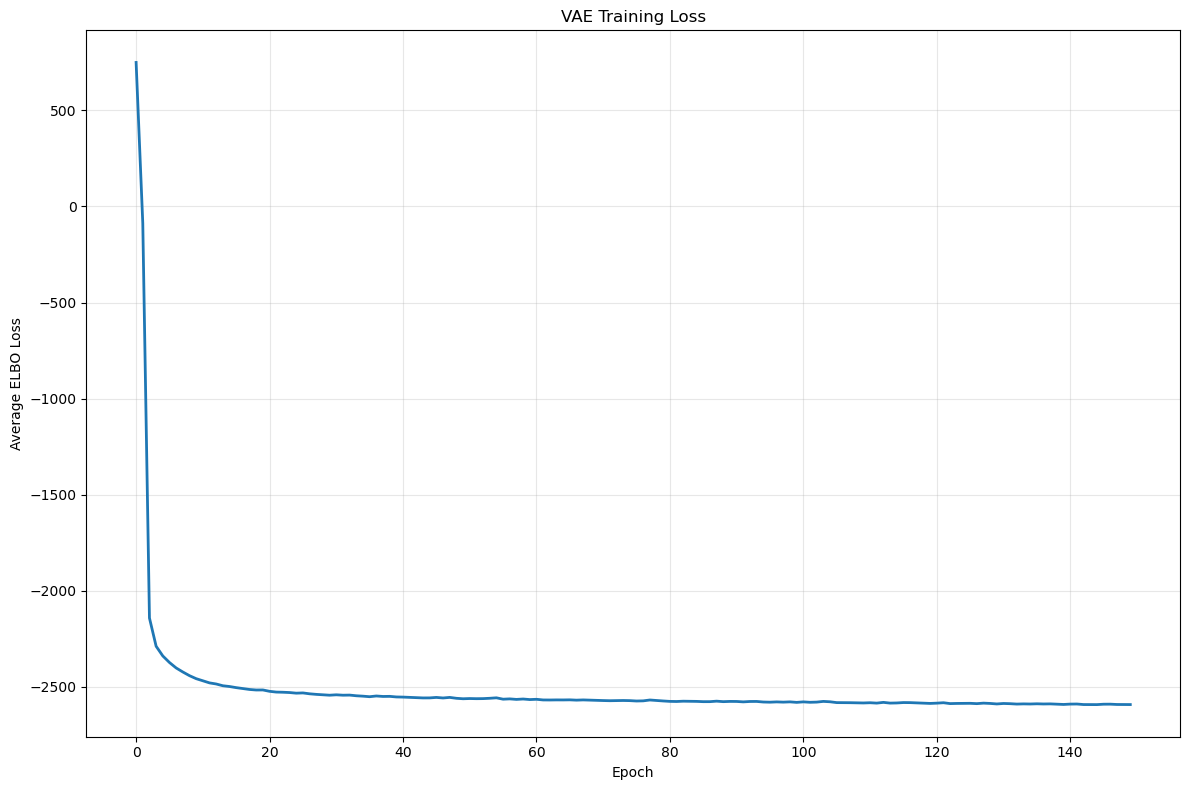

Starting evaluation...
Evaluation complete. Processed 88839 samples.


In [13]:
embedder = BertLogEmbedder()
embedder.fit(train_df)

data = load_dataset(
    train_df,
    test_df,
    window_size='10m',
    step_size='1m',
    n_prediction_window=5,
    filter_strategy='combined',
    filter_params={'contamination':0.1},
    batch_size=4096,
    embedder=embedder,
    mode='hybrid',
    debug=True
)


vae = LogAnomalyVAE(
    input_dim=data['input_dim'],
    z_dim=64,
    hidden_dim=256,
    use_cuda=(data["device"].type == "cuda")
)

train_vae(
    vae,
    data,
    num_epochs=150,
    batch_size=4096,
    lr=1e-4,
    debug=True
)

scores, labels = test_vae(
    vae,
    data,
    eval_batch_size=8192
)

pred_types = data['pred_types_test']
failure_types = data['failure_types_test']
failure_map = data['failure_map_test']


True

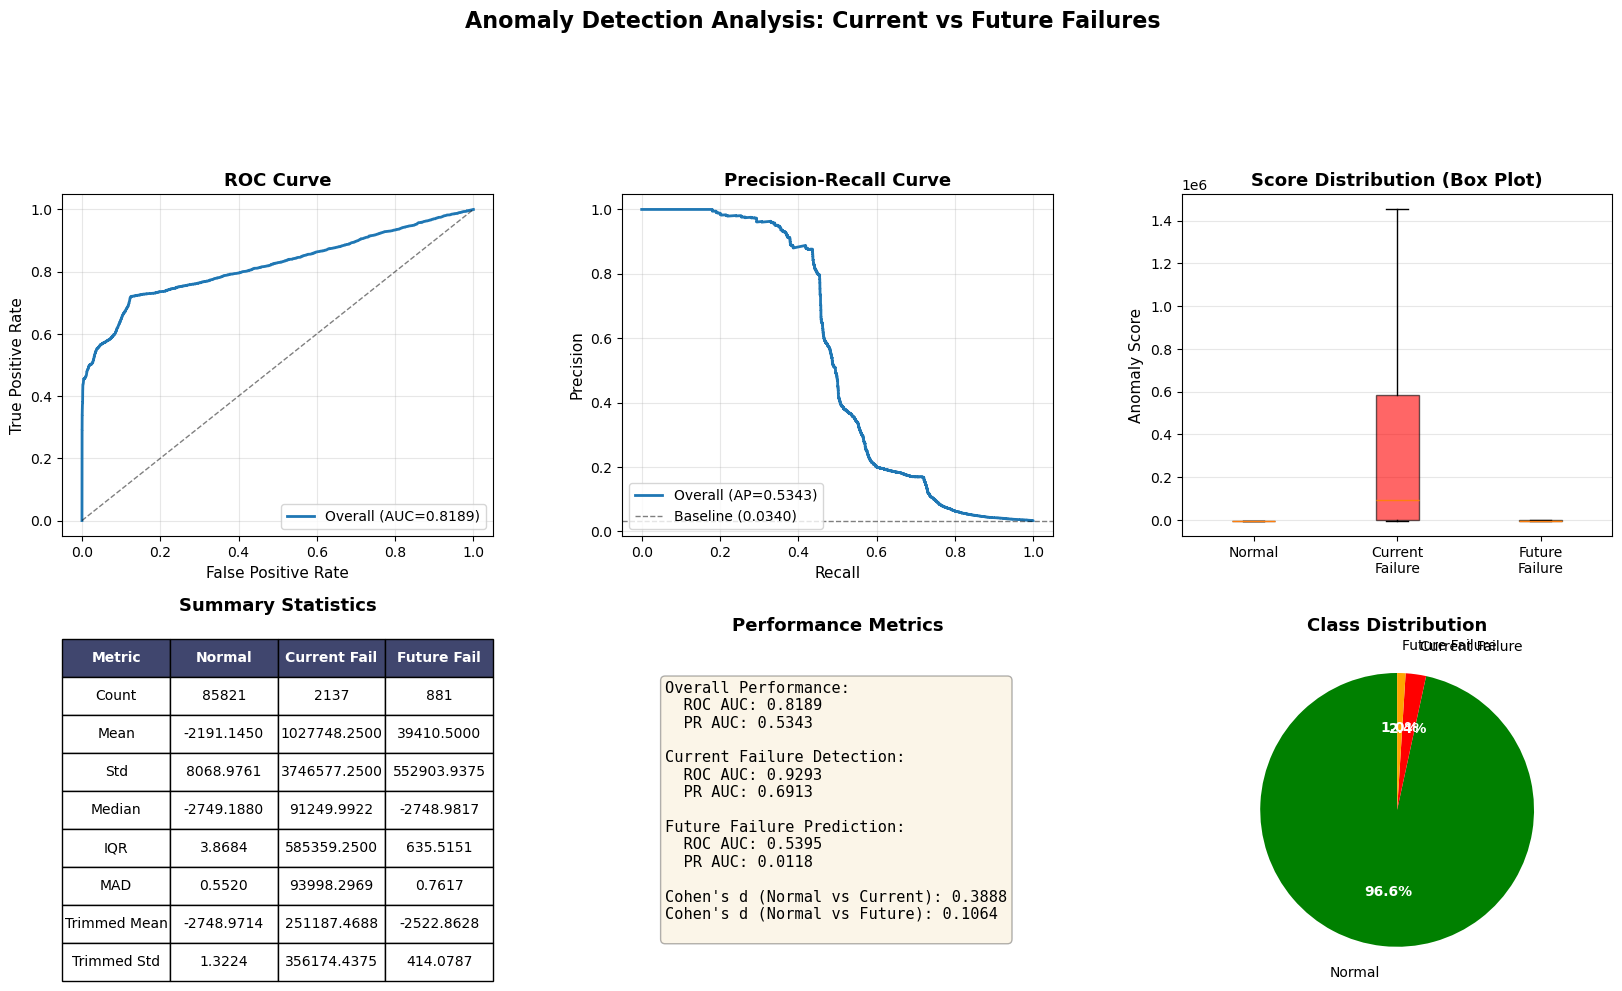

In [14]:
plot_anomaly_detection_analysis(scores, labels, pred_types)
True

Analyzing 27 failure types...


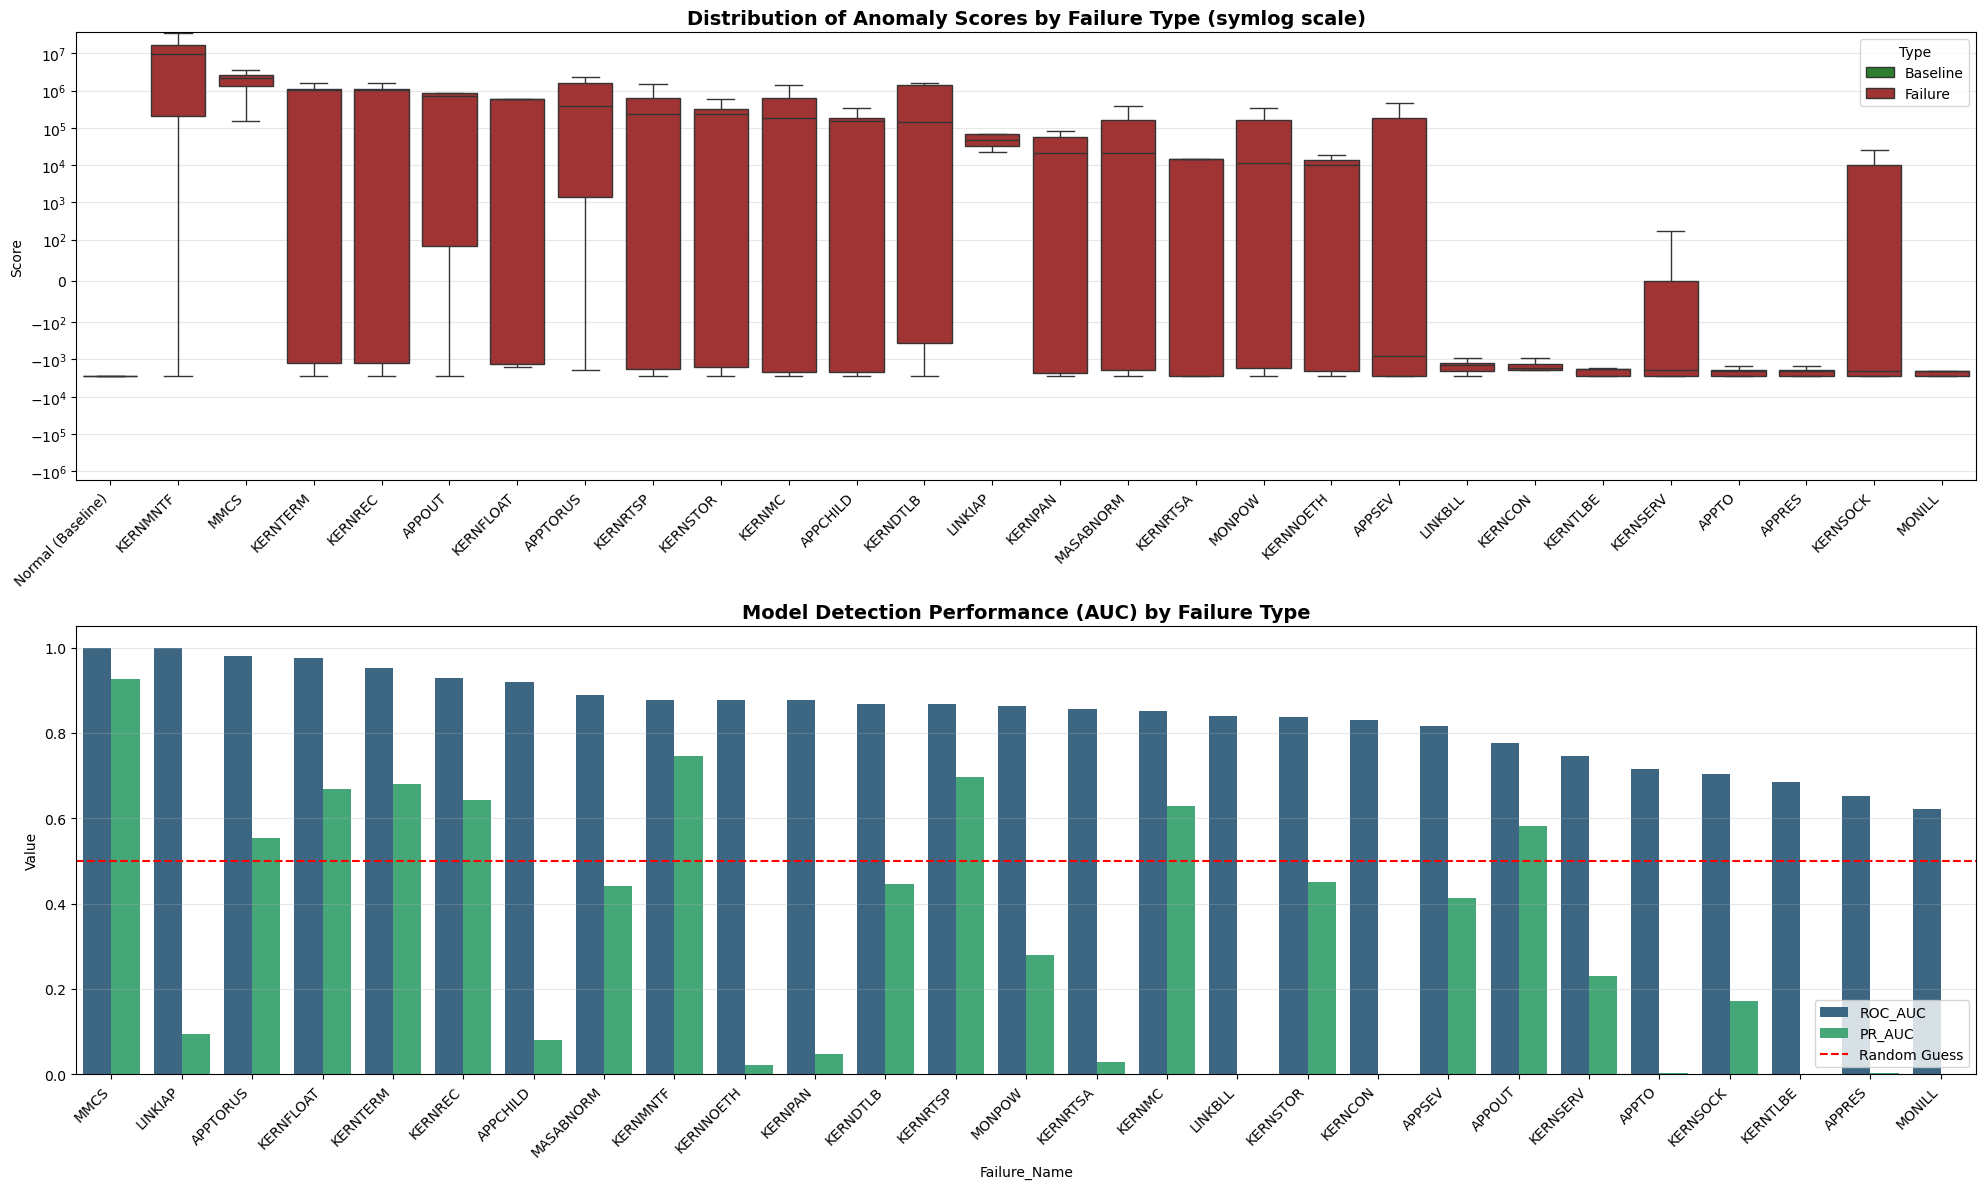

,Failure_Name,Count,ROC_AUC,PR_AUC,Mean_Score,Median_Score,Std_Score
24,MMCS,15,0.999963,0.926612,1.960534e+06,2.160005e+06,1.018149e+06
22,LINKIAP,18,0.998854,0.093989,4.874603e+04,4.755049e+04,1.707135e+04
5,APPTORUS,30,0.981369,0.552878,7.734287e+05,3.809817e+05,8.390916e+05
8,KERNFLOAT,15,0.975074,0.667339,3.934647e+05,5.843415e+05,2.793895e+05
19,KERNTERM,108,0.951415,0.679554,7.840022e+05,1.070661e+06,5.725998e+05
13,KERNREC,122,0.929759,0.642535,7.031589e+05,1.065495e+06,5.868427e+05
0,APPCHILD,15,0.919918,0.079706,1.237945e+05,1.488280e+05,9.876680e+04
23,MASABNORM,285,0.888823,0.440382,9.239481e+05,2.047953e+04,3.675156e+06
10,KERNMNTF,160,0.878189,0.745281,9.691205e+06,9.625730e+06,1.005178e+07
11,KERNNOETH,30,0.877677,0.021373,7.474410e+03,1.007227e+04,7.602413e+03


In [15]:
plot_failure_analysis(scores, labels, pred_types, failure_types, failure_map)

## Create Predictor

In [16]:
to_remove = [
    '-','KERNTLBE', 'KERNSERV', 'MONILL', 'APPTO',
    'APPRES', 'MONPOW', 'MMCS', 'KERNPROG', 'KERNSOC'
]

remaining = (
    df.select("Label")
      .unique()
      .filter(~pl.col("Label").is_in(to_remove))
)['Label'].to_list()

df_isolate = df.with_columns(
    pl.col("Label")
      .is_in(remaining)
      .alias("Anomaly")
)
df_isolate['Label'].value_counts()

Label,count
str,u32
"""APPSEV""",49651
"""KERNBIT""",1
"""KERNMC""",342
"""APPCHILD""",320
"""KERNMICRO""",1503
…,…
"""LINKIAP""",166
"""APPTORUS""",10
"""KERNPAN""",18


In [17]:
def find_optimal_threshold(y_true, scores):
    precision, recall, thresholds = precision_recall_curve(y_true, scores)
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
    
    f1_scores = np.nan_to_num(f1_scores)
    
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_f1

In [41]:
def plot_predictor_dashboard(y_true, scores, y_pred, threshold, fpr_label=None):
    fig = plt.figure(figsize=(20, 6))
    
    ax1 = plt.subplot(1, 3, 1)
    
    normal_scores = scores[y_true == 0]
    anomaly_scores = scores[y_true == 1]
    
    bins = 50
    ax1.hist(normal_scores, bins=bins, alpha=0.6, color='green', label='Normal', density=True, log=True)
    ax1.hist(anomaly_scores, bins=bins, alpha=0.6, color='red', label='Anomaly', density=True, log=True)
    
    line_label = f'Threshold ({threshold:.1f})'
    if fpr_label:
        line_label += f"\n[{fpr_label}]"

    ax1.axvline(threshold, color='black', linestyle='--', linewidth=2, label=line_label)
    
    ax1.set_xscale('symlog', linthresh=100)
    
    ax1.set_title("Anomaly Score Distribution", fontsize=12, fontweight='bold')
    ax1.set_xlabel("Anomaly Score (SymLog Scale)")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = plt.subplot(1, 3, 2)
    precision, recall, _ = precision_recall_curve(y_true, scores)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='purple', lw=2, label=f'PR AUC = {pr_auc:.4f}')
    
    from sklearn.metrics import precision_score, recall_score
    curr_prec = precision_score(y_true, y_pred)
    curr_rec = recall_score(y_true, y_pred)
    
    ax2.plot(curr_rec, curr_prec, 'o', markersize=10, color='black', label='Selected Threshold')
    
    ax2.set_title("Precision-Recall Curve", fontsize=12, fontweight='bold')
    ax2.set_xlabel("Recall (Sensitivity)")
    ax2.set_ylabel("Precision")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax3 = plt.subplot(1, 3, 3)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Pred Normal', 'Pred Anomaly'],
                yticklabels=['True Normal', 'True Anomaly'], ax=ax3, annot_kws={"size": 14})
    
    ax3.set_title("Confusion Matrix", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def evaluate_predictor(vae, data, threshold=None, fpr_target=None):
    print("\n--- Initializing Anomaly Predictor ---")
    
    X_test = data["X_test"]
    y_test = data["y_test"].cpu().numpy()
    
    scores = []
    batch_size = 4096
    
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            batch_scores = vae.get_anomaly_score(batch, n_samples=10)
            scores.append(batch_scores.cpu().numpy())
            
    scores = np.concatenate(scores)
    
    thresh_label = None

    if threshold is not None:
        print(f"Using Manual Threshold: {threshold:.4f}")
        thresh_label = "Manual"
        
    elif fpr_target is not None:
        print(f"Optimizing threshold for {fpr_target*100}% False Positive Rate...")
        normal_scores = scores[y_test == 0]
        threshold = np.percentile(normal_scores, 100 - (fpr_target * 100))
        print(f"FPR Target Threshold Found: {threshold:.4f}")
        thresh_label = f"Target FPR: {fpr_target*100}%"
        
    else:
        print("Optimizing threshold for Max F1-Score...")
        best_thresh, best_f1 = find_optimal_threshold(y_test, scores)
        print(f"Optimal Threshold Found: {best_thresh:.4f} (Max F1: {best_f1:.4f})")
        threshold = best_thresh
        thresh_label = "Max F1-Score"

    y_pred = (scores > threshold).astype(int)
            
    print("\n" + "="*40)
    print(f"PREDICTOR REPORT (Threshold > {threshold:.2f})")
    print("="*40)
    
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Actual Specificity (Normal Accuracy): {specificity:.4f}")
    
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))    
    
    plot_predictor_dashboard(y_test, scores, y_pred, threshold, fpr_label=thresh_label)
    
    return {
        'threshold': threshold,
        'y_pred': y_pred,
        'scores': scores,
    }

## Balanced


--- Initializing Anomaly Predictor ---
Optimizing threshold for Max F1-Score...
Optimal Threshold Found: 14334.4082 (Max F1: 0.5816)

PREDICTOR REPORT (Threshold > 14334.41)
Actual Specificity (Normal Accuracy): 0.9979
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99     85821
     Anomaly       0.88      0.43      0.58      3018

    accuracy                           0.98     88839
   macro avg       0.93      0.71      0.78     88839
weighted avg       0.98      0.98      0.98     88839



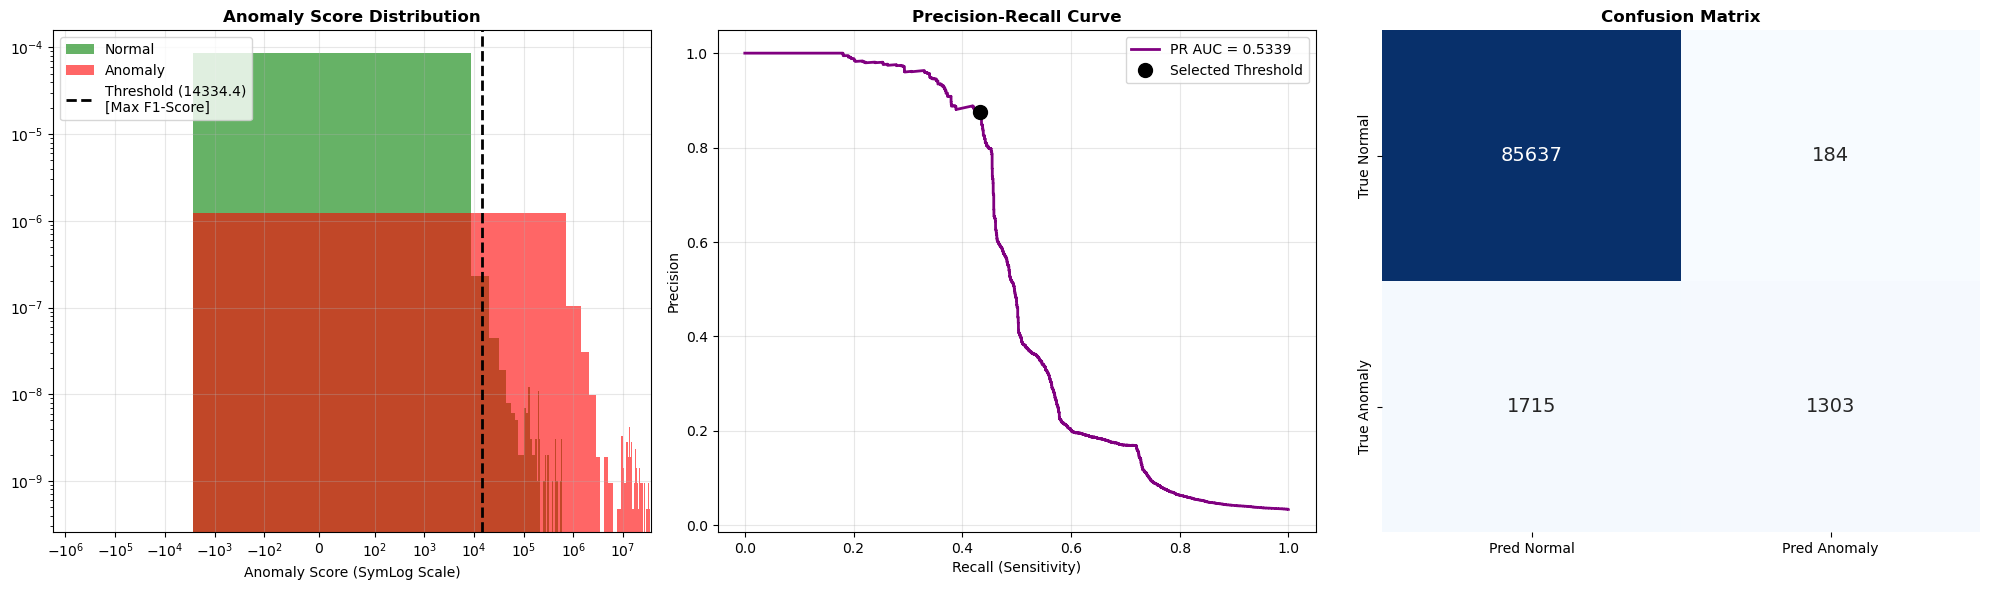

{'threshold': np.float32(14334.408),
 'y_pred': array([0, 0, 0, ..., 0, 0, 0], shape=(88839,)),
 'scores': array([-1695.9762, -1723.5079, -1729.0576, ..., -2749.6794, -2748.531 ,
        -2749.061 ], shape=(88839,), dtype=float32)}

In [80]:
results = evaluate_predictor(vae, data)
results

## Focus on finding anomalies


--- Initializing Anomaly Predictor ---
Optimizing threshold for 10.0% False Positive Rate...
FPR Target Threshold Found: -1954.9108

PREDICTOR REPORT (Threshold > -1954.91)
Actual Specificity (Normal Accuracy): 0.9000
              precision    recall  f1-score   support

      Normal       0.99      0.90      0.94     85821
     Anomaly       0.18      0.64      0.29      3018

    accuracy                           0.89     88839
   macro avg       0.59      0.77      0.61     88839
weighted avg       0.96      0.89      0.92     88839



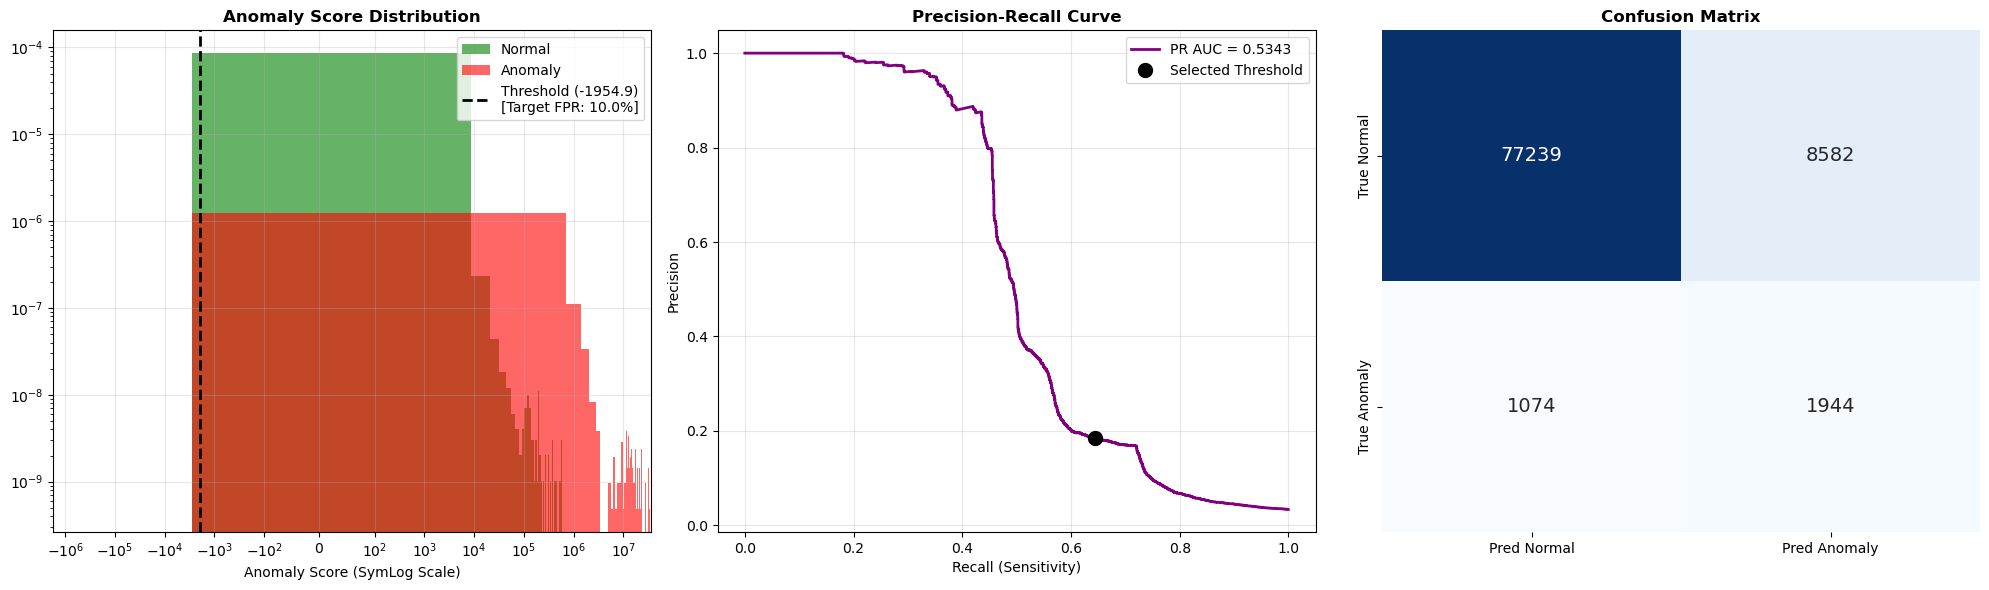

{'threshold': np.float32(-1954.9108),
 'y_pred': array([1, 1, 1, ..., 0, 0, 0], shape=(88839,)),
 'scores': array([-1688.7356, -1715.0399, -1699.5139, ..., -2749.7422, -2749.3083,
        -2749.4502], shape=(88839,), dtype=float32)}

In [75]:
results = evaluate_predictor(vae, data, fpr_target=0.1)
results

In [76]:
def evaluate_prediction_types(vae, data, threshold):    
    X_test = data["X_test"]
    pred_types = data["pred_types_test"].cpu().numpy() 
    
    scores = []
    batch_size = 4096
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch = X_test[i : i + batch_size]
            batch_scores = vae.get_anomaly_score(batch, n_samples=5)
            scores.append(batch_scores.cpu().numpy())
    scores = np.concatenate(scores)
    
    df = pd.DataFrame({
        'Score': scores,
        'Type_ID': pred_types
    })
    
    type_map = {0: 'Normal', 1: 'Clear Failure (Current)', 2: 'Future Failure (Predict)'}
    df['Type'] = df['Type_ID'].map(type_map)
    
    df['Detected'] = df['Score'] > threshold
    
    stats = df.groupby('Type').agg(
        Count=('Score', 'count'),
        Mean_Score=('Score', 'mean'),
        Median_Score=('Score', 'median'),
        Detection_Rate=('Detected', 'mean')
    ).reindex(['Normal', 'Clear Failure (Current)', 'Future Failure (Predict)'])
    
    print("\nStatistics per Prediction Type:")
    print(stats)
    
    fig = plt.figure(figsize=(18, 6))
    
    ax1 = plt.subplot(1, 3, 1)
    sns.boxplot(data=df, x='Type', y='Score', order=type_map.values(), 
                palette=['forestgreen', 'firebrick', 'orange'], ax=ax1, showfliers=False)
    
    ax1.axhline(threshold, color='black', linestyle='--', linewidth=2, label='Alert Threshold')
    ax1.set_yscale('symlog', linthresh=100) # Crucial for your data scale
    ax1.set_title('Anomaly Scores by Context', fontweight='bold')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, axis='y', alpha=0.3)
    
    ax2 = plt.subplot(1, 3, 2)
    
    colors = ['green', 'red', 'orange']
    bars = ax2.bar(stats.index, stats['Detection_Rate'] * 100, color=colors, alpha=0.7)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
        
    ax2.set_ylabel('Detection Rate (%)')
    ax2.set_title(f'Detection Rate (Threshold > {threshold:.1f})', fontweight='bold')
    ax2.set_ylim(0, 110)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, axis='y', alpha=0.3)

    ax3 = plt.subplot(1, 3, 3)
    
    sns.kdeplot(data=df[df['Type'] == 'Normal'], x='Score', fill=True, color='green', label='Normal', ax=ax3)
    sns.kdeplot(data=df[df['Type'] == 'Future Failure (Predict)'], x='Score', fill=True, color='orange', label='Future Failure', ax=ax3)
    
    ax3.axvline(threshold, color='black', linestyle='--')
    ax3.set_xscale('symlog', linthresh=100)
    ax3.set_title('Density: Normal vs Future Failure', fontweight='bold')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()


Statistics per Prediction Type:
                          Count    Mean_Score  Median_Score  Detection_Rate
Type                                                                       
Normal                    85821 -2.187011e+03  -2749.370605        0.099777
Clear Failure (Current)    2137  1.024950e+06  91249.992188        0.836219
Future Failure (Predict)    881  4.510305e+04  -2749.152832        0.177072


/tmp/ipykernel_891483/3512782183.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Score', order=type_map.values(),


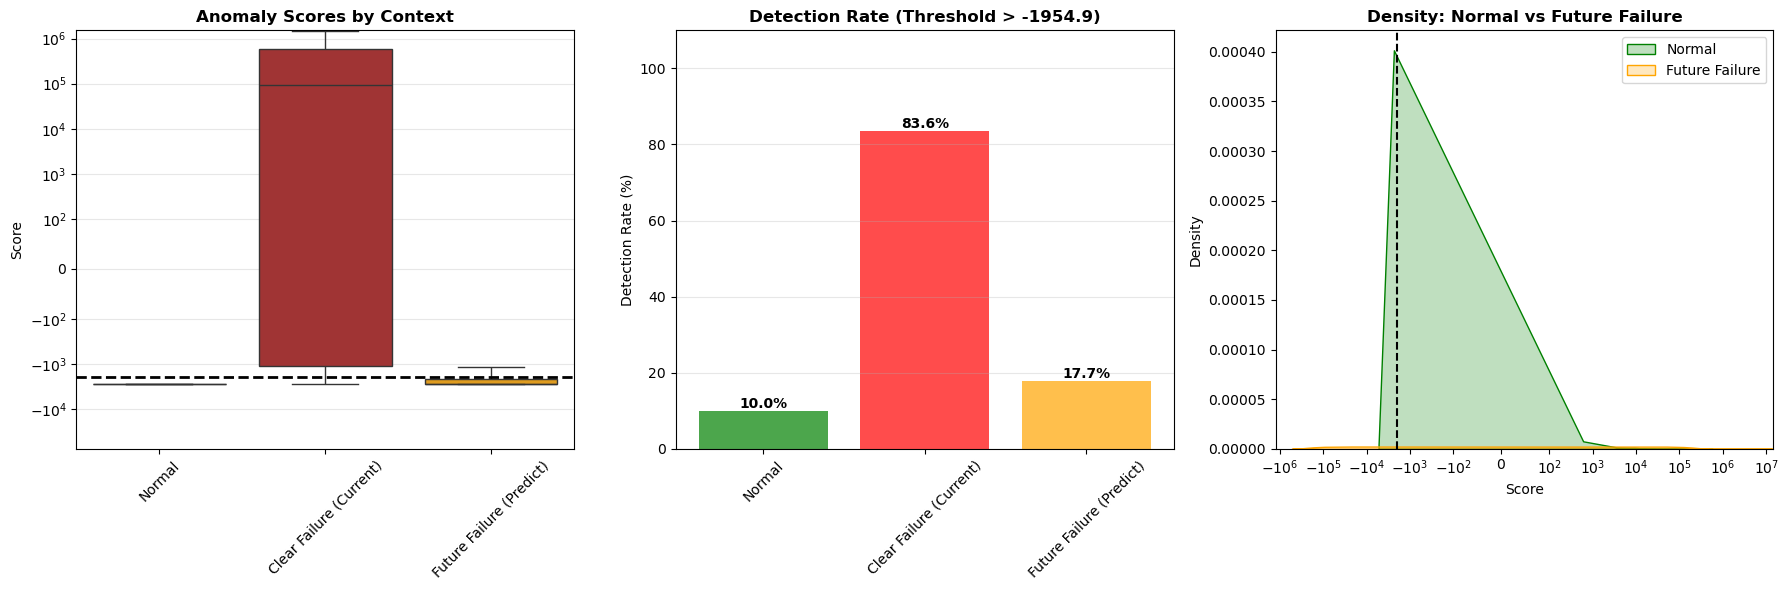

In [77]:
evaluate_prediction_types(vae, data, results['threshold'])

In [78]:
def analyze_caught_failures(vae, data, threshold=None, fpr_target=0.10):
    print(f"\n--- Analyzing Predictable Failures ---")
    
    X_test = data["X_test"]
    failure_types_tensor = data["failure_types_test"] 
    pred_types = data["pred_types_test"].cpu().numpy()
    
    scores = []
    vae.eval()
    with torch.no_grad():
        for i in range(0, len(X_test), 4096):
            batch = X_test[i : i + 4096]
            scores.append(vae.get_anomaly_score(batch, n_samples=5).cpu().numpy())
    scores = np.concatenate(scores)
    
    mask_normal = pred_types == 0
    normal_scores = scores[mask_normal]
    if not threshold:
        threshold = np.percentile(normal_scores, 100 - (fpr_target * 100))
    print(f"Threshold set to: {threshold:.2f}")
    
    mask_future = pred_types == 2
    future_indices = np.where(mask_future)[0]
    
    future_scores = scores[future_indices]
    future_failures = failure_types_tensor[future_indices].cpu().numpy()
    
    caught_mask = future_scores > threshold
    caught_indices = np.where(caught_mask)[0]
    
    print(f"Total Future Failures: {len(future_indices)}")
    print(f"Caught Future Failures: {len(caught_indices)} ({len(caught_indices)/len(future_indices)*100:.1f}%)")
    
    failure_map = data['failure_map_train']
    
    caught_counts = {}
    total_counts = {}
    
    for i in range(len(future_failures)):
        active_failures = np.where(future_failures[i] == 1)[0]
        for idx in active_failures:
            try:
                name = failure_map[idx]
                total_counts[name] = total_counts.get(name, 0) + 1
            except KeyError:
                pass
            
    for i in caught_indices:
        active_failures = np.where(future_failures[i] == 1)[0]
        for idx in active_failures:
            try:
                name = failure_map[idx]
                caught_counts[name] = caught_counts.get(name, 0) + 1    
            except KeyError:
                pass
            
    results = []
    for name, total in total_counts.items():
        caught = caught_counts.get(name, 0)
        rate = caught / total if total > 0 else 0
        results.append({
            "Failure Type": name,
            "Total Instances": total,
            "Predicted": caught,
            "Success Rate": rate
        })
        
    df_res = pd.DataFrame(results).sort_values(by="Success Rate", ascending=False)
    return df_res

df_res = analyze_caught_failures(vae, data, threshold=results['threshold'])
df_res


--- Analyzing Predictable Failures ---
Threshold set to: -1954.91
Total Future Failures: 881
Caught Future Failures: 168 (19.1%)


,Failure Type,Total Instances,Predicted,Success Rate
8,APPSEV,10,10,1.000000
14,KERNBIT,5,5,1.000000
6,KERNPOW,35,20,0.571429
5,KERNMC,37,17,0.459459
20,APPUNAV,10,4,0.400000
4,KERNTERM,30,11,0.366667
17,APPRES,15,5,0.333333
7,KERNPAN,15,5,0.333333
19,APPTORUS,10,3,0.300000
18,KERNRTSP,90,22,0.244444



--- Predictability by Category ---
                        Total_Instances  Total_Predicted  Success_Rate
Category                                                              
Kernel (OS/Hardware)                979              189      0.193054
Application (Software)              472               90      0.190678


/tmp/ipykernel_891483/1924285695.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_stats.index, y=category_stats['Success_Rate'] * 100, palette='viridis')


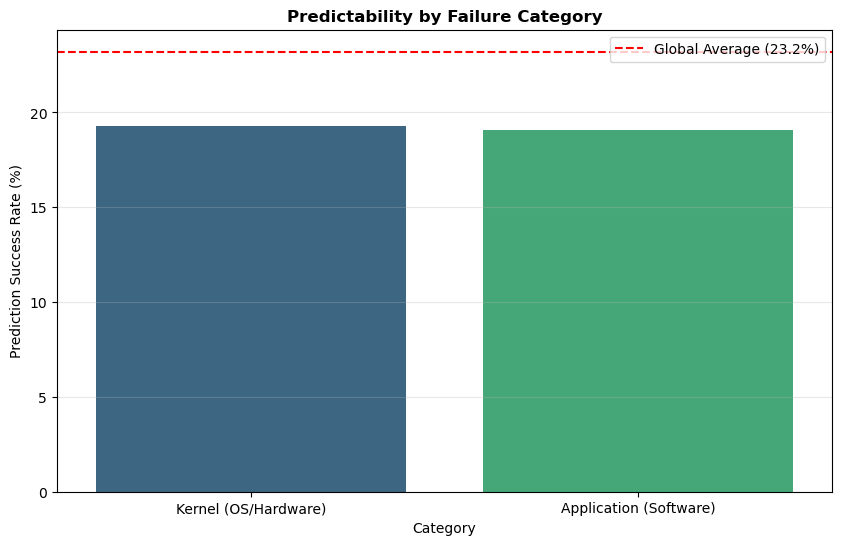

In [79]:
def analyze_failure_categories(df_results):
    def get_category(name):
        if name.startswith('APP'): return 'Application (Software)'
        if name.startswith('KERN'): return 'Kernel (OS/Hardware)'
        if name.startswith('LINK'): return 'Link (Network)'
        if name.startswith('MON') or name.startswith('MAS'): return 'System Monitor'
        return 'Other'

    df_results['Category'] = df_results['Failure Type'].apply(get_category)
    
    category_stats = df_results.groupby('Category').agg(
        Total_Instances=('Total Instances', 'sum'),
        Total_Predicted=('Predicted', 'sum')
    )
    
    category_stats['Success_Rate'] = category_stats['Total_Predicted'] / category_stats['Total_Instances']
    category_stats = category_stats.sort_values(by='Success_Rate', ascending=False)
    
    print("\n--- Predictability by Category ---")
    print(category_stats)
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_stats.index, y=category_stats['Success_Rate'] * 100, palette='viridis')
    plt.ylabel('Prediction Success Rate (%)')
    plt.title('Predictability by Failure Category', fontweight='bold')
    plt.axhline(y=23.2, color='red', linestyle='--', label='Global Average (23.2%)')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.show()

analyze_failure_categories(df_res)